# Bootstrapping SE's and CI's with Grad School Data

**Instructions:**

The goal of this exercise is to become familiar with the technique of
bootstrapping. Bootstrapping can be used to estimate the precision
of statistics through resampling data. It is especially useful when there is no explicit formula available for the precision of a statistic, although it also works perfectly well even when there is. In other words, we can use bootstrapping to generate standard errors and
confidence intervals on pretty much any kind of analysis.

In this example, we will examine whether GRE scores predict future GPA.


**What to do:**

Login to learning catalytics and join the session for the
module entitled "Grad School Correlations". You will answer a series of
questions based on the guided programming below. Read through the comments and follow the instructions provided.
In some cases you will be asked to answer a question, clearly indicated
by 'QUESTION'. In other cases, you be asked to supply missing code,
indicated by 'TODO'. The corresponding question in learning catalytics
will be indicated in parentheses (e.g. Q1). If there is no 'Q#'
accompanying a 'QUESTION' just type your answer into this script and
discuss it with your team. 

Original source of exercise:
Efron, B. & Tibshirani Robert, J. (1993) An introduction to the
bootstrap. Chapman & Hall, London, see Table 3.2 on p. 21

RTB wrote it 07 July 2019 (Kinsale, Ireland; Cork Distance Week,
"Champion of Champions" day), ERBB translated to Python on 04 August, 2021. JP generated non-pandas version 25 Jun 2022.


**Concepts covered:**
1. Standard error of the mean calculated 3 ways:
      a) formula, b) population sampling, c) bootstrap sampling
2. Calculating correlation coefficients with 'corr'
3. Bootstrapping standard errors with the built-in 'bootstrp' function
4. Bootstrapping confidence intervals with the built-in 'bootci' function
5. Parametric bootstrap by sampling from a bivariate normal distribution

The data here are GRE (quant) and GPA (science) scores from a census of
82 graduate programs in neuroscience. We also have a random sample of 15
schools from this census as well. Note that these data were collected
prior to August of 2011, so the GRE scores were scaled from 200 to 800.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Makes the figures look pretty
import seaborn as sns
sns.set(rc={'figure.figsize':(10, 5)})


In [2]:
# Read in the data.
# ds82 will be our "population", and ds15 will be our "random sample" from the population.
# (That is, ds15 is a subset of ds82)
ds82 = np.asarray(pd.read_excel('https://github.com/jonahpearl/TAD_python/blob/student_branch/data/Grad_School_82.xlsx?raw=true')) # All graduate programs (*census*)
ds15 = np.asarray(pd.read_excel('https://github.com/jonahpearl/TAD_python/blob/student_branch/data/Grad_School_15.xlsx?raw=true')) # Random sample of 15

# Define cols
ID_COL = 0
GRE_COL = 1
GPA_COL = 2

# Define a few constants
n_boot = 10000
n_samp = ds15.shape[0]
n_census = ds82.shape[0]

ds15

array([[  4.  , 653.  ,   3.12],
       [  6.  , 576.  ,   3.39],
       [ 13.  , 635.  ,   3.3 ],
       [ 15.  , 661.  ,   3.43],
       [ 31.  , 605.  ,   3.13],
       [ 35.  , 578.  ,   3.03],
       [ 36.  , 572.  ,   2.88],
       [ 45.  , 545.  ,   2.76],
       [ 47.  , 651.  ,   3.36],
       [ 50.  , 555.  ,   3.  ],
       [ 52.  , 580.  ,   3.07],
       [ 53.  , 594.  ,   2.96],
       [ 70.  , 666.  ,   3.44],
       [ 79.  , 558.  ,   2.81],
       [ 82.  , 575.  ,   2.74]])

In [3]:
# Run a simple linear regression on GPA vs GRE
# See: https://numpy.org/doc/stable/reference/generated/numpy.linalg.lstsq.html

A = np.vstack([ds15[:,GRE_COL], np.ones(ds15.shape[0])]).T
ds15_slope, ds15_intercept = np.linalg.lstsq(A, ds15[:,GPA_COL], rcond=None)[0]

A = np.vstack([ds82[:,GRE_COL], np.ones(ds82.shape[0])]).T
ds82_slope, ds82_intercept = np.linalg.lstsq(A, ds82[:,GPA_COL], rcond=None)[0]

Text(0, 0.5, 'GPA (science)')

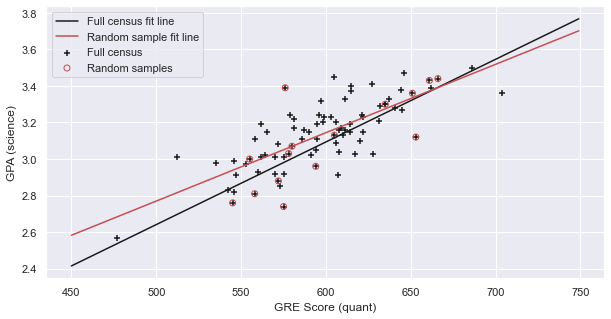

In [4]:
# Plot the results

# Make the figure
plt.figure(figsize=(10,5))

# Plot the raw data
plt.scatter(ds82[:,GRE_COL], ds82[:,GPA_COL], marker='+', color='k', label='Full census')
plt.scatter(ds15[:,GRE_COL], ds15[:,GPA_COL], marker='o', color='r', facecolor='none', label='Random samples')

# Plot the fit lines
xvals = np.arange(450,750)
plt.plot(xvals, xvals*ds15_slope + ds15_intercept, 'k', label='Full census fit line')
plt.plot(xvals, xvals*ds82_slope + ds82_intercept, 'r', label='Random sample fit line')

# Add legend based on our assigned labels
plt.legend()

# Label axes
plt.xlabel('GRE Score (quant)')
plt.ylabel('GPA (science)')

## Mean GRE score & standard error (SE)
We start with something that is easy to compute directly. The reason we
can do this is that, thanks to the Central Limit Theorem, we KNOW that
the sampling distribution of the mean, regardless of the distribution of
the original data from which the mean was calculated, will be normally
distributed. Furthermore, we know that the standard deviation of the
sampling distribution for the mean will be equal to the sample standard
deviation divided by the square-root of the number of samples. This is
the standard error of the mean.

NOTE: There are two standard deviations at play here. The first is the
standard deviation that we calculate from our sample--this is the sample
standard deviation. But, in the next sections, we will be explicitly
calculating the "sampling distribution of the mean," which is the
distribution of mean values we would get if we re-took our sample of 15
many different times and calculated a new sample mean each time. The
standard deviation of the sampling distribution of the mean is, by
definition, the standard error. In fact, and this is very important to
just flat out memorize until practice makes it intuitive: THE STANDARD
ERROR OF ANY STATISTIC IS THE STANDARD DEVIATION OF THE SAMPLING
DISTRIBUTION OF THAT STATISTIC. The mean is a special case where we can
use a handy-dandy formula to calculate the standard deviation of the
sampling distribution (i.e. the standard error of the mean) based on the
standard deviation of our single sample.

*Python note*: Pandas and matlab both divide by n - 1 when they compute standard deviation. In numpy, the std is computed by dividing by n, unless you change the `ddof` (delta degrees of freedom) argument to be 1.


In [1]:
# TODO: Calculate the mean GRE score for your sample. 
# Then calculate the standard error of the mean (SEM) using the formula: SEM = std(sample) / sqrt(N)

mean_GRE = ...
sem_GRE = ...

sem_GRE

SyntaxError: invalid syntax (3302396114.py, line 4)


**QUESTION (Q1)**: What is the value of semGRE to 2 decimal places?


# Bootstrapping

## "True" standard error by sampling from the population

Here, we "bootstrap" from the entire population, which is a contrived scenario just for sake of comparison. This isn't really bootstrapping!!

Normally, we don't have access to the entire population, and so we won't be able to do this!




Text(0.5, 1.0, 'Distribution of means, sampling from CENSUS')

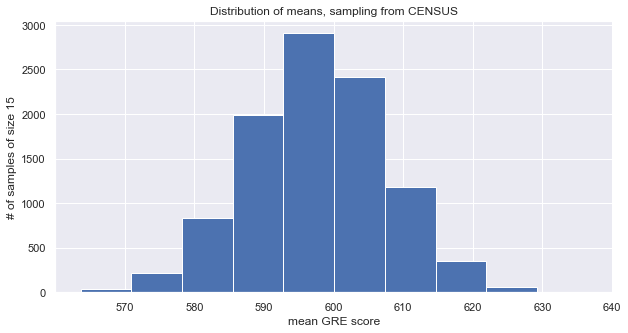

In [6]:
all_means = np.zeros(n_boot,)

np.random.seed(123) # for consistency across class; You would not normally do this.

for k in range(n_boot):

    # TODO: Draw n_boot samples of size 15 (n_samp) from the CENSUS of 82, each time 
    # calculating the sample mean. Save each mean in 'all_means'
    all_means[k] = ...

# Look at the sampling distribution of the mean
plt.hist(all_means, bins = 10)
plt.xlabel('mean GRE score')
plt.ylabel('# of samples of size 15')
plt.title('Distribution of means, sampling from CENSUS')

In [7]:
# TODO: calculate the standard error of the mean from this sample:
sem_GRE_samp = ...

sem_GRE_samp

9.871243503975931

**QUESTION** (Q2): What is the value of `sem_GRE_samp` to 2 decimal places? 

## Bootstrap standard error by sampling from the sample

Calculate another SEM as you did above, but now, instead of drawing your samples from the CENSUS, you will draw your samples from the SAMPLE. This is a more realistic simulation of what you might do in a scientific setting, since you will normally not have access to the full population.

You do this by sampling WITH REPLACEMENT from your original actual sample of the 15 graduate schools. This is the essence of the bootstrap!

Hint: you should only have to change one key aspect of your code from above.




Text(0.5, 1.0, 'Distribution of means, sampling from SAMPLE')

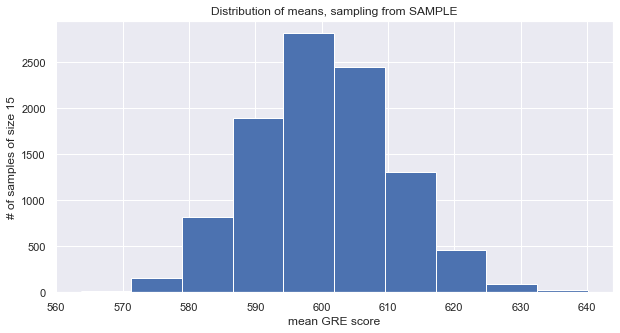

In [9]:
all_means_bootstrap = np.zeros(n_boot,)

np.random.seed(123) 
for k in range(n_boot):

    # TODO: sample with replacement from the sample and get mean
    all_means_bootstrap[k] = ...

# Visualize the sampling distribution of the mean
plt.hist(all_means_bootstrap, bins = 10)
plt.xlabel('mean GRE score')
plt.ylabel('# of samples of size 15')
plt.title('Distribution of means, sampling from SAMPLE')

In [10]:
# TODO: calculate the standard error of the mean from the bootstrap 
#      sampling distribution of the means
sem_GRE_boot = ...

sem_GRE_boot

10.497182381287697

**QUESTION** (Q3): What is the value of `sem_GRE_boot` to 2 decimal places? 


**QUESTION** (Q4): What is the error (in %) of the bootstrap estimate w/r/t that of the formula? Calculate in next cell. Round to the nearest whole number in %.



In [11]:
# TODO: Compare your bootstrap estimate of the SE with that from the formula
percent_error = ...

percent_error

3.0

# Correlation of GRE and GPA in census and sample

In [12]:
# TODO: Use np.corrcoef() to calculate the correlation coefficients between GPA and GRE in both ds15 and ds82 

rho_hat_82 = 
rho_hat_15 = 

print(rho_hat_82)
print(rho_hat_15)

0.7599978555038982
0.776374491289407


**QUESTION (Q5)**: What is a correlation coefficient?

**QUESTION (Q6)**: What is the correlation coefficient for the census? 

**QUESTION (Q7)**: Based on the correlation coefficient and the graph, would you guess GRE score and GPA are correlated?


Standard error for the correlation coefficient (sampled from sample)



Unlike for the mean, there is no handy, dandy formula for the standard error of a correlation coefficient. Now we really do need the bootstrap!

Get a bootstrap sample of correlation coefficients the old fashioned way, using a 'for' loop.

[Text(0.5, 0, 'Correlation coefficient'), Text(0, 0.5, 'Probability')]

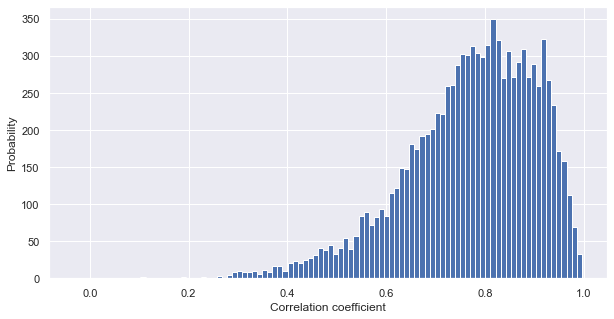

In [13]:
np.random.seed(123) # for reproducibility

rhos_sample = np.zeros(n_boot,)

for k in range(n_boot):

    # TODO: Randomly sample n_samp rows from ds15 with replacement
    rows_to_use = ...
    sampled_rows = ...
    
    # TODO: Compute the correlation of GRE score and GPA for this sample
    rhos_sample[k] = ...

_ = plt.hist(rhos_sample, bins=100)

# Label the plot
# (gca() is "get current axis;" equivalent to doing plt.xlabel() and plt.ylabel() separately)
plt.gca().set(xlabel = 'Correlation coefficient', ylabel = 'Probability')  

In [14]:
# Compute standard error of our correlation coefficient
se_rho_boot = ...

se_rho_boot

0.1341215819062771

**QUESTION (Q8)**: What is the value of `se_rho_boot` (referred to as `se_rho_boot_FL` in learning catalytics) to 4 decimal places?



In [15]:
# Compute mean of distribution
mean_rho_boot = ...

mean_rho_boot

0.7699396400904741

**QUESTION (Q9)**: What is the mean of this distribution to 2 decimal places?


Q10/Q11/Q12 are specific to Matlab

## "True" standard error (sample from census)

As we did above for the mean, we can take advantage of the fact that we
have data for the complete population (i.e. census), and see how our
estimate of rho is distributed when we repeatedly sample from the
population. That is, instead of re-sampling our sample of 15 with
replacement, we sample the 'population' of 82 graduate schools with
replacement.


[Text(0.5, 0, 'Correlation coefficient'), Text(0, 0.5, 'Probability')]

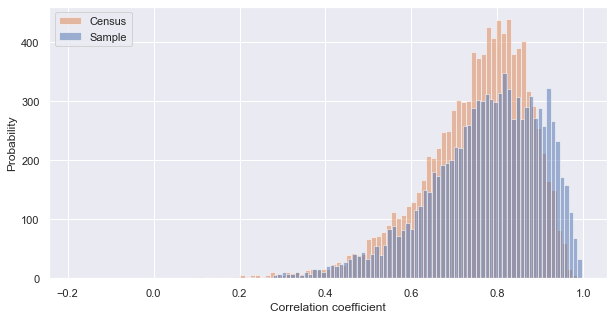

In [16]:
np.random.seed(123) # for reproducibility

rhos_census = np.zeros(n_boot,)

for k in range(n_boot):

    # TODO: Randomly sample n_samp rows from ds15 with replacement
    rows_to_use = ...
    sampled_rows = ...
    
    # TODO: Compute the correlation of GRE score and GPA for this sample
    rhos_census[k] = ...

_ = plt.hist(rhos_census, bins=100, alpha=0.5, label='Census', color='C1')  # you can access the matplotlib colors with "CN", 0 <= N <= 9
_ = plt.hist(rhos_sample, bins=100, alpha=0.5, label='Sample', color='C0')
plt.legend()

# Label the plot
# (gca() is "get current axis;" equivalent to doing plt.xlabel() and plt.ylabel() separately)
plt.gca().set(xlabel = 'Correlation coefficient', ylabel = 'Probability')  

**QUESTION (Q13)**: How does this distribution compare to the bootstrapped resampling of 15 schools? Consider the general skew, spread, location (i.e. mean,median) of the distributions.

**Question (Q14)**: Compute the standard error of the correlation coefficient for the samples bootstrapped from the population.

In [17]:
# TODO: Compute the standard error of the correlation coefficient for the samples 
# bootstrapped from the population.
se_rho_boot_TS = ...

se_rho_boot_TS

0.12890407481088867

## The 'parametric bootstrap' (p. 53 of E&T)

"Instead of sampling with replacement from the data, we draw B samples of
size n from the parametric estimate of the population."

The parametric bootstrap differs from the traditional bootstrap in that
we fit a model to the data and then draw random numbers from this fitted
model, rather than resampling the data itself. Why might one want to do
this? Well, in rare instances when one wants to bootstrap the SE for some
sample 'outlier', such as the 'min' or 'max', the data-driven bootstrap
will fail. (Try this and see for yourself what is going on.) In such
cases, the parametric bootstrap gets it right.

In this case, we will assume that the population has a bivariate normal
distribution, with means `mu_hat` and a covariance matrix of `cov_hat`.




In [18]:
mu_hat = ds15[:,[GRE_COL, GPA_COL]].mean(axis=0)
cov_hat = np.cov(ds15[:,[GRE_COL, GPA_COL]], rowvar=False) 
cov_hat

array([[1.74678095e+03, 7.90152381e+00],
       [7.90152381e+00, 5.92980952e-02]])

(Recall covariance is un-normalized correlation, so the diagonals aren't 1, but the variance of each variable.)

Using what we learned from bootstrapping, create a 'for' loop that uses the `np.random.multivariate_normal` function to draw n_boot samples of size `n_samp` from a bivariate normal distribution with mean `mu_hat` and covariance `cov_hat`. Compute the correlation coefficient for each sample and store in the column called `pbs_rhos` of our pandas dataframe `rhos`, which is initialized below. 

In [19]:
rhos_parametric = np.zeros((n_boot,))

np.random.seed(123)
for k in range(n_boot):

    # TODO: Draw samples from normal distribution
    R = ...

    # TODO: Compute correlation coefficient (use np.corrcoef)
    rhos_parametric[k] = ...

**QUESTION (Q15)**: What is the standard error of the correlation coefficient as determined by parametric bootstrapping? Compute in code below

In [20]:
# TODO: get standard error of correlation coefficient from parametric bootstrapping
se_rho_PBS = ...

se_rho_PBS

0.11800679354379039

[Text(0.5, 0, 'Correlation coefficient'), Text(0, 0.5, 'Probability')]

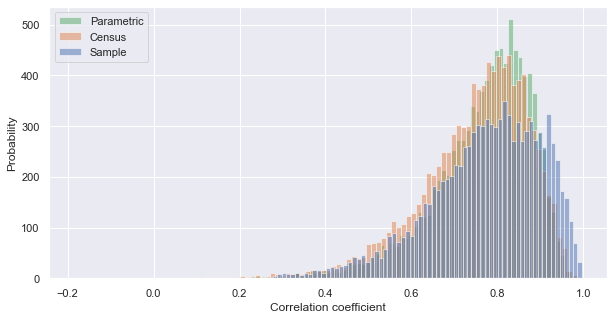

In [21]:
_ = plt.hist(rhos_parametric, bins=100, alpha=0.5, label='Parametric', color='C2')
_ = plt.hist(rhos_census, bins=100, alpha=0.5, label='Census', color='C1')  # you can access the matplotlib colors with "CN", 0 <= N <= 9
_ = plt.hist(rhos_sample, bins=100, alpha=0.5, label='Sample', color='C0')

plt.legend()

# Label the plot
plt.gca().set(xlabel = 'Correlation coefficient', ylabel = 'Probability')  

In [22]:
print(se_rho_boot)
print(se_rho_boot_TS)
print(se_rho_PBS)

0.1341215819062771
0.12890407481088867
0.11800679354379039


**QUESTION (Q16)**: How does the SE of the correlation coefficient compare to our other bootstrapping strategies? If it's different, why do you think this may be so?


Answer: When a model fits the data properly, simulating from the model as we 
have above generates more accurate estimates for the same sampling n than 
re-sampling our data. Thus, the standard error for the correlation 
coefficient is smaller here than our other bootstrapping methods. 
HOWEVER, this assumption only works if our model is appropriate. If 
inappropriate, we will converge on an incorrect answer. This is one 
example of a trade-off between bias and variance.

For good measure, note that we can also plot the histograms in a grouped manner, if we pass the arrays as a list:

[Text(0.5, 0, 'Correlation coefficient'), Text(0, 0.5, 'Probability')]

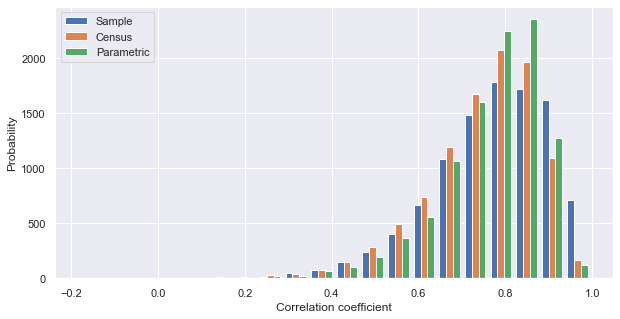

In [23]:
_ = plt.hist([rhos_sample, rhos_census, rhos_parametric], bins=20, label=['Sample', 'Census', 'Parametric'])
plt.legend()
plt.gca().set(xlabel = 'Correlation coefficient', ylabel = 'Probability')  

# Confidence intervals

We have used several different strategies to create sampling
distributions:
  1. Repeated sampling from the entire population.
  2. Repeated re-sampling from our original sample (bootstrap)
  3. Repeated sampling from a population defined by parameters derived
     from our original sample (parametric bootstrap)

But in each case, we have generated an estimate of the sampling
distribution for a given statistic. Thus far, we have used these
distributions to generate a single estimate of precision: the standard
error. However, we can use these same distributions to calculate other
measures of precision, such as confidence intervals. After all, under
normal assumptions, a standard error is a kind of confidence interval,
since we expect about 68% of the distribution to be within +/- s.d. That
is, for example, the SEM can be thought of as defining a 68% CI for our
estimate of the mean. But we can go further.


## CI by asymptotic normal distribution theory

Since the std. error is the 68% CI, we can get any other CI by just calculating the appropriate number of standard deviates from the normal distribution. Let's use this to get 95% CI's based on our bootstrap sample (rhos_sample) above.

In [24]:
# This is our mean correlation
mean_rho_boot = rhos_sample.mean()

# This is our 68% CI
se_rho_boot = rhos_sample.std(ddof=1)

# Set alpha for a 95% CI
my_alpha = 0.05

You probably remember that a 95% CI is +/- 1.96 standard deviates. So we
could calculate our CI as `mean_rho_boot` +/- 1.96*`se_rho_boot`. But say we
wanted to be able to calculate any arbitrary confidence interval. For a
99% CI, we would set `my_alpha` to 0.01.


In [25]:
# TODO: Write a line of code that will convert a desired CI, 
#       expressed as my_alpha to the appropriate number of standard deviates. 
#       Use `norm` from scipy.stats, imported below
from scipy.stats import norm
num_std_deviates = ...

**QUESTION (Q17)**: What is `num_std_deviates` for `my_alpha` = 0.001?

In [26]:
# TODO: Calculate the lower and upper bounds for the 95% CI
rho95_CI_low = ...
rho95_CI_hi = ...

print(rho95_CI_low)
print(rho95_CI_hi)

0.507066170004632
1.032813110176316


**QUESTION (Q18)**: What is the value of `rho95_CI_hi`?

**QUESTION (Q19)**: Does this value make sense? Why or why not?

Whoops, we have a correlation value over 1! That happens because the normal distribution's density extends out to infinity, whereas correlations only range from -1 to 1. We could fix this by applying a transformation to move the r values from [-1,1] to [-inf, inf] (see Fisher Transformation subsection at https://stats.stackexchange.com/questions/226380/derivation-of-the-standard-error-for-pearsons-correlation-coefficient). We could also use the percentile method, which is the way we choose below.

[Text(0.5, 0, 'Correlation coefficient'),
 Text(0, 0.5, 'Probability'),
 Text(0.5, 1.0, 'Distribution of rho values: boostrap'),
 (0.15, 1.1)]

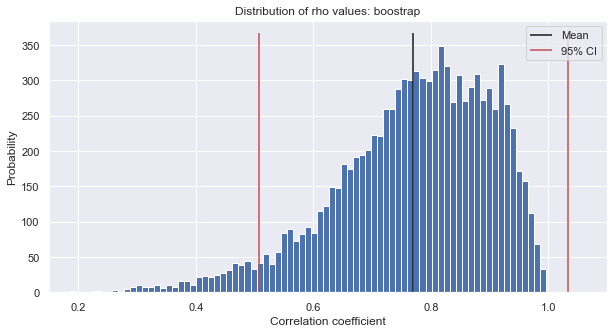

In [27]:
# Plot of distribution of bootstrapped correlation coefficients
_ = plt.hist(rhos_sample, bins=100)

# Add vertical lines to mark mean, CIs
ylims = plt.ylim()
plt.vlines(mean_rho_boot, *ylims, color='k', label='Mean')

# # TODO: Draw lines for the mean and 95% CI on our histogram. Be sure to label them!
plt.vlines(...)
plt.vlines(...)

plt.legend()
plt.gca().set(xlabel = 'Correlation coefficient', ylabel = 'Probability',
       title = 'Distribution of rho values: boostrap',
       xlim = [0.15, 1.1])

##  CI by percentile method

In this case, we generated 10,000 samples, so a more intuitive, brute-force way to calculate the 95% CI is just to sort our bootstrap replicates and then find the values corresponding to 250th and the 9750th index in the sorted array.


In [28]:
# Sort our bootstrap replicates
bs_rhos_sorted = np.sort(rhos_sample)

# TODO: find indices corresponding to lower and upper bounds
idx_lo = ...
idx_hi = ...

# Get high and low bounds using percentiles
rho95_CI_percentile_low = bs_rhos_sorted[int(idx_lo)]
rho95_CI_percentile_hi = bs_rhos_sorted[int(idx_hi)]

print(rho95_CI_percentile_low)
print(rho95_CI_percentile_hi)

0.45275195586778294
0.9626295335238724


**QUESTION (Q20)**: What is the lower bound of the 95% CI?


[Text(0.5, 0, 'Correlation coefficient'),
 Text(0, 0.5, 'Probability'),
 Text(0.5, 1.0, 'Distribution of rho values: boostrap'),
 (0.15, 1.1)]

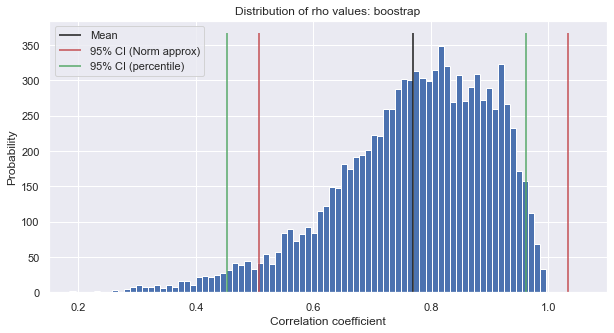

In [29]:
# Plot of distribution of bootstrapped correlation coefficients
_ = plt.hist(rhos_sample, bins=100)

# Add vertical lines to mark mean, CIs
ylims = plt.ylim()
plt.vlines(mean_rho_boot, *ylims, color='k', label='Mean')

# # TODO: Add lines for the percentile method CI's 
plt.vlines(...)
plt.vlines(...)

plt.legend()
plt.gca().set(xlabel = 'Correlation coefficient', ylabel = 'Probability',
       title = 'Distribution of rho values: boostrap',
       xlim = [0.15, 1.1])

Question 21 is specific to Matlab

**QUESTION (Q22)**: Think about this confidence interval and your earlier guess about whether GRE score and GPA are correlated. How can you use this to generate a hypothesis test? (i.e. Can we say that GRE and GPA are significantly correlated at p < 0.05?)

**QUESTION (Q23)**: Today we've explored bootstrapping as a way to estimate standard errors and confidence intervals for means and correlation coefficients. Which of these measures are the most robust across our different ways of bootstrapping and estimating? Which are more sensitive to the method we chose?



Answer: In general, measures like means and standard errors are pretty
robust and we can estimate them pretty precisely with only a few hundred
bootstrap replicates. However, the closer we get to the tails of the
distribution (e.g. estimating 95% or 99% Confidence Intervals) the more
replicates we need to get a robust estimate and the more things like bias
correction and bootstrapping method matter. For example, Efron &
Tibshirani recommend a minimum of several thousand bootstrap replicates
when estimating confidence intervals.

NOTE: An entire chapter of E&T is devoted to "Better bootstrap confidence
intervals," where they describe the method known as "bias corrected and
accelerated" (or BCA), which is the default method for 'bootci'. See
chapters 14 and 22 of E&T if you crave mathematical details.